In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasGridSearch

### READ DATA ###

df = pd.read_csv('Punta_Salute_2009.csv', sep=';')
df = df.dropna()

In [2]:
df

,Data,Ora solare,Livello P.Salute Canal Grande (cm)
0,01-gen-09,01:00,34.0
1,01-gen-09,02:00,37.0
2,01-gen-09,03:00,36.0
3,01-gen-09,04:00,29.0
4,01-gen-09,05:00,20.0
...,...,...,...
8755,31-dic-09,20:00,49.0
8756,31-dic-09,21:00,69.0
8757,31-dic-09,22:00,85.0
8758,31-dic-09,23:00,97.0


<AxesSubplot:>

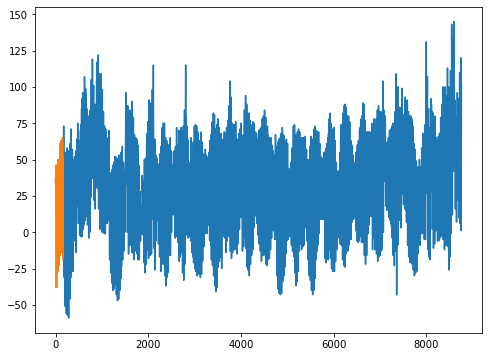

In [4]:
df['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))
df[:7*24]['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))

In [5]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [69]:
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
dim=24
def T2V_NN(param):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [7]:
### PREPARE DATA TO FEED MODELS ###

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [15]:
train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6132, 24, 1) (6132, 1)
(2604, 24, 1) (2604, 1)


In [73]:
param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 200,
    'batch_size': [512,1024]
}


In [ ]:
### FIT T2V + LSTM ###
es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
kgs_t2v = KerasGridSearch(T2V_NN, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

In [28]:
pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

2.0710664785527175

In [30]:
kgs_t2v.best_score

3.66899

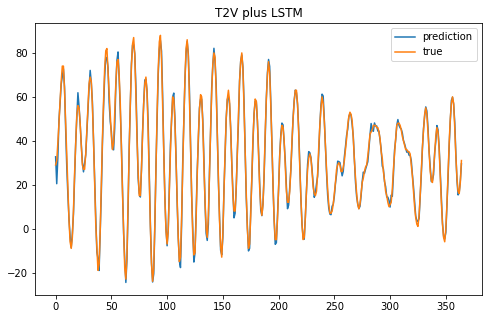

In [21]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [25]:
del param_grid['t2v_dim']

{'unit': [64, 32],
 'lr': [0.01, 0.001],
 'act': ['elu', 'relu'],
 'epochs': 200,
 'batch_size': [512, 1024]}

作为对比，拟合一个简单的LSTM

In [26]:
### FIT SIMPLE LSTM ###
es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: NN(param=x, dim=sequence_length)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


16 trials detected for ('unit', 'lr', 'act', 'epochs', 'batch_size')

***** (1/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})


C:\Users\ASUS\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


SCORE: 162.69057 at epoch 8

***** (2/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 109.89171 at epoch 10

***** (3/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 526.79352 at epoch 4

***** (4/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 3.98499 at epoch 48

***** (5/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 6.01605 at epoch 28

***** (6/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 14.85231 at epoch 53

***** (7/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 5.8034 at epoch 62

***** (8/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 11.19497 at epoch 135

***** (9/16) *****
Search({'unit': 32, 'lr': 0.01, 'act': '

In [27]:
pred = kgs.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred)

1.949525034418487

In [32]:
kgs_t2v.best_model.layers[1](X_train)

<tf.Tensor: shape=(6132, 24, 129), dtype=float32, numpy=
array([[[ 0.98590136,  0.88047874,  0.9895088 , ..., -0.88675094,
          0.4081091 , -1.6262245 ],
        [ 0.9472808 ,  0.9186039 ,  0.99969816, ..., -0.92896354,
          0.44244748, -1.7713    ],
        [ 0.96283764,  0.906666  ,  0.9979072 , ..., -0.9159323 ,
          0.4310697 , -1.7229415 ],
        ...,
        [-0.63215846, -0.26410767, -0.40817973, ...,  0.4471099 ,
         -0.16072747,  0.59826577],
        [ 0.10565707,  0.17019846,  0.18059087, ..., -0.04312882,
          0.02828907, -0.12711151],
        [ 0.6728147 ,  0.49833634,  0.6156608 , ..., -0.43359756,
          0.1790977 , -0.7074133 ]],

       [[ 0.9472808 ,  0.9186039 ,  0.99969816, ..., -0.92896354,
          0.44244748, -1.7713    ],
        [ 0.96283764,  0.906666  ,  0.9979072 , ..., -0.9159323 ,
          0.4310697 , -1.7229415 ],
        [ 0.99546444,  0.8020787 ,  0.94085133, ..., -0.79643506,
          0.34959772, -1.3844321 ],
        ..

In [147]:
from tensorflow.keras import backend as K
from tensorflow import keras 
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))
#
class AttentionBlock(tf.keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size
        self.attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        # self.ff_conv2 at build()
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention(inputs, inputs)
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)

        x = self.ff_norm(inputs + x)
        return x
#
class ModelTrunk(tf.keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        if ff_dim is None:
            ff_dim = head_size
        self.dropout = dropout
        self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
        #self.pooling=tf.keras.layers.AveragePooling1D(pool_size=4,data_format='channels_first')
        self.final_layer = Sequential([
                Bidirectional(LSTM(128)),
                Dense(32, activation='selu'),
                Dense(1)])
    def call(self, inputs):
        time_embedding = tf.keras.layers.TimeDistributed(self.time2vec)(inputs)
        #time_embedding=inputs
        #print(time_embedding.shape)
        x = K.concatenate([inputs, time_embedding], -1)
        for attention_layer in self.attention_layers:
            x = attention_layer(x)
        x=  self.final_layer(x)
        return x # flat vector of features out

In [149]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 5, 0.9)
es = EarlyStopping(monitor='val_loss',mode='min', patience=35, verbose=1,restore_best_weights=True)
checkpoint_filepath = f"folds1.tf"
model = ModelTrunk(ff_dim=64,num_heads=4,num_layers=2,)
model.compile(optimizer="adam",loss = "mae")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 128,
                        callbacks = [es,tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/10
48/48 [==============================] - 21s 358ms/step - loss: 25.4587 - val_loss: 24.7011
Epoch 2/10
48/48 [==============================] - 17s 353ms/step - loss: 23.2916 - val_loss: 23.2629
Epoch 3/10
48/48 [==============================] - 16s 337ms/step - loss: 17.9008 - val_loss: 20.6093
Epoch 4/10
48/48 [==============================] - 16s 340ms/step - loss: 16.2374 - val_loss: 19.4206
Epoch 5/10
48/48 [==============================] - 16s 338ms/step - loss: 15.3367 - val_loss: 18.2247
Epoch 6/10
48/48 [==============================] - 16s 337ms/step - loss: 14.2932 - val_loss: 17.4102
Epoch 7/10
48/48 [==============================] - 16s 338ms/step - loss: 12.3209 - val_loss: 14.4868
Epoch 8/10
48/48 [==============================] - 16s 337ms/step - loss: 10.3932 - val_loss: 11.9102
Epoch 9/10
48/48 [==============================] - 16s 337ms/step - loss: 9.1091 - val_loss: 9.8900
Epoch 10/10
48/48 [==============================] - 16s 339ms/step - loss:

In [150]:
pred =model.predict(X_test)

In [152]:
mean_absolute_error(y_test.ravel(), pred)

9.074774936194919